# get FESOM-REcoM output at SOCAT/SOCCOM locations


In [ ]:
#get_ipython().system(u'jupyter nbconvert --to=python MASTER_flux_seasonal_cycle_subareas.ipynb')

In [1]:
### modules
import os
import sys
sys.path.append('/home/ollie/jhauck/py_fesom/modules/')
import numpy as np
from scipy import stats
import skill_metrics as sm #module installed on ollie
import seawater as sw
import matplotlib
#matplotlib.use('Agg') #changing backend
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from time import localtime, gmtime, strftime
from scipy import signal
from annualmean import annualmean
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from matplotlib import cm 
import numpy as np
from math import sin, cos, sqrt, atan2, radians, degrees
from numba import njit
from load_mesh_data_new import *

In [2]:
simulation = 'A'

# specify years to average over
year1 = 1970 # years to average: e.g. 1982,2008,2013 each until 2018
year2 = 2018
eval_time = np.arange(year1,year2+1) 
gcb_time = np.arange(year1+1./24,year2+1,step=1./12)      
tsteps = (1+year2-year1)*12  
print eval_time
print tsteps

# SOCAT is on 1x1 grid already
# SOCCOM is ungridded: find closest node, assign month; (regridded vs native mesh)

# NOTE: 
# the landsea mask in the netcdf files is the one from RECCAP
#    i.e., it was used in the re-gridding of the model output to the regular 1x1 grid
#    (some of the SOCAT observations end up on land in the colocation procedure because of this mask, i.e., 
#     the total number of SOCAT points in model-based mask can be different from number of filled grid 
#     points in original SOCAT file)

# produced masks: 
# 1) SOCAT only    done
# 2) SOCCOM only   done
# 3) SOCAT+SOCCOM  done
# 4) ideal sampling grid?

savepath = '/work/ollie/ncara/RECCAPv2/subsampling/' 

#-----
# data files
#-----

# SOCAT
socatfile = '/work/ollie/jhauck/gcp2018/2019_data/SOCATv2019_tracks_gridded_monthly.nc'

# FESOM-REcoM output 
path = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019_post_processed_for_masks/'
pco2file = path+'spco2_fesom_A_reg_1970_2019.nc'
SSTfile  = path+'tos_fesom_A_reg_1970_2019.nc' # practical salinity!
SSSfile  = path+'sos_fesom_A_reg_1970_2019.nc'
Chlfile  = path+'chlos_fesom_A_reg_1970_2019.nc'
MLDfile  = path+'mld_fesom_A_reg_1970_2019.nc'
SSHfile  = path+'zos_fesom_A_reg_1970_2019.nc'

# SOCCOM
soccomfile = '/work/ollie/ncara/observations/SOCCOM_floats/soccom_float_pco2_2020.04.20_created_2020_05_14.nc'


[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018]
588


In [3]:
#-------
# land-sea mask
#-------

path_lsmask = '/work/ollie/ncara/RECCAPv2/reccap2ocean_regions.nc'
f3 = Dataset(path_lsmask)
mask_reccap = np.squeeze(f3.variables['reccap2_ocean_regions'][:,:])
#lon_ls_mask = np.squeeze(f3.variables['lon'][:])
#print lon_ls_mask

ls_mask_reccap = np.ones_like(mask_reccap) # 1=ocean, 0=land
ls_mask_reccap[mask_reccap==0]=0

#ind_land = ls_mask_reccap==0
print ls_mask_reccap.shape
print ls_mask_reccap

(180, 360)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]


In [4]:
#------
# READ DATA
#------

# model
a1 = Dataset(pco2file)
a2 = Dataset(SSTfile)
a3 = Dataset(SSSfile)
a4 = Dataset(Chlfile)
a5 = Dataset(MLDfile)
a6 = Dataset(SSHfile)
lat_model  = a1.variables['Lat'][:]
lon_model  = a1.variables['Lon'][:]
pco2_model = a1.variables['spco2'][0:588,:,:] # skip year 2019 (not in SOCAT file)
sst_model  = a2.variables['tos'][0:588,:,:]
sss_model  = a3.variables['sos'][0:588,:,:]
chl_model  = a4.variables['chlos'][0:588,:,:]
mld_model  = a5.variables['mld'][0:588,:,:]
ssh_model  = a6.variables['zos'][0:588,:,:]  
print pco2_model.shape

# socat
b1 = Dataset(socatfile)
lat_socat  = b1.variables['ylat'][:]
lon_socat  = b1.variables['xlon'][:]
spco2_socat = b1.variables['fco2_ave_unwtd'][:,:,:] 
spco2_socat[spco2_socat == -1.e+34] = np.nan 
spco2_socat = np.ma.filled(spco2_socat, fill_value=np.nan) 
print spco2_socat.shape

# change lon in SOCAT file to be consistent with model output
spco2_socatB = np.empty_like(spco2_socat)
spco2_socatB[:,:,:180] = spco2_socat[:,:,180:]
spco2_socatB[:,:,180:] = spco2_socat[:,:,:180]
lon_socatB = np.empty_like(lon_socat)
lon_socatB[:180] = lon_socat[180:]
lon_socatB[180:] = lon_socat[:180]
lon_socatB[lon_socatB<0]=lon_socatB[lon_socatB<0]+360

# SOCCOM
c1 = Dataset(soccomfile)
time_soccom = c1.variables['Time'][:]
lat_soccom  = c1.variables['Lat'][:]
lon_soccom  = c1.variables['Lon'][:]
spco2_soccom = c1.variables['pCO2'][:]


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


(588, 180, 360)
(588, 180, 360)


In [5]:

print pco2_model.shape
print spco2_socatB.shape
        
print ''
print np.min(lat_model)
print np.max(lat_model)
print np.min(lat_socat)
print np.max(lat_socat)

print ''
print np.min(lon_model)
print np.max(lon_model)
print np.min(lon_socat)
print np.max(lon_socat)
print np.min(lon_soccom)
print np.max(lon_soccom)

print ''
#print lon_socat[0]
print lon_socatB[0]
print lon_model[0]
#print lon_socat
#print lon_socatB



(588, 180, 360)
(588, 180, 360)

-89.5
89.5
-89.5
89.5

0.5
359.5
-179.5
179.5
0.001
359.987

0.5
0.5


In [6]:
#-----
# get model output at SOCAT locations
#-----

indNaN = ~np.isnan(spco2_socatB)
print indNaN.shape

pco2_model_at_socat = -9999*np.ones_like(spco2_socatB)
sst_model_at_socat = -9999*np.ones_like(spco2_socatB)
sss_model_at_socat = -9999*np.ones_like(spco2_socatB)
chl_model_at_socat = -9999*np.ones_like(spco2_socatB)
mld_model_at_socat = -9999*np.ones_like(spco2_socatB)
ssh_model_at_socat = -9999*np.ones_like(spco2_socatB)   

pco2_model_at_socat[indNaN] = pco2_model[indNaN]
sst_model_at_socat[indNaN] = sst_model[indNaN]
sss_model_at_socat[indNaN] = sss_model[indNaN]
chl_model_at_socat[indNaN] = chl_model[indNaN]
mld_model_at_socat[indNaN] = mld_model[indNaN]
ssh_model_at_socat[indNaN] = ssh_model[indNaN]   

#print pco2_model_at_socat.shape
#print pco2_model_at_socat
print 'Min pCO2: ',np.nanmin(pco2_model_at_socat)
print 'Max pCO2: ',np.nanmax(pco2_model_at_socat)
print 'Min SST: ',np.nanmin(sst_model_at_socat)
print 'Max SST: ',np.nanmax(sst_model_at_socat)
print 'Min SSS: ',np.nanmin(sss_model_at_socat)
print 'Max SSS: ',np.nanmax(sss_model_at_socat)
print 'Min Chl: ',np.nanmin(chl_model_at_socat)
print 'Max Chl: ',np.nanmax(chl_model_at_socat)
print 'Min MLD: ',np.nanmin(mld_model_at_socat)
print 'Max MLD: ',np.nanmax(mld_model_at_socat)
print 'Min SSH: ',np.nanmin(ssh_model_at_socat)
print 'Max SSH: ',np.nanmax(ssh_model_at_socat)

(588, 180, 360)
Min pCO2:  -9999.0
Max pCO2:  1023.73
Min SST:  -9999.0
Max SST:  31.3524
Min SSS:  -9999.0
Max SSS:  39.4234
Min Chl:  -9999.0
Max Chl:  7.42927
Min MLD:  -9999.0
Max MLD:  2886.74
Min SSH:  -9999.0
Max SSH:  1.19903


[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]]
[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


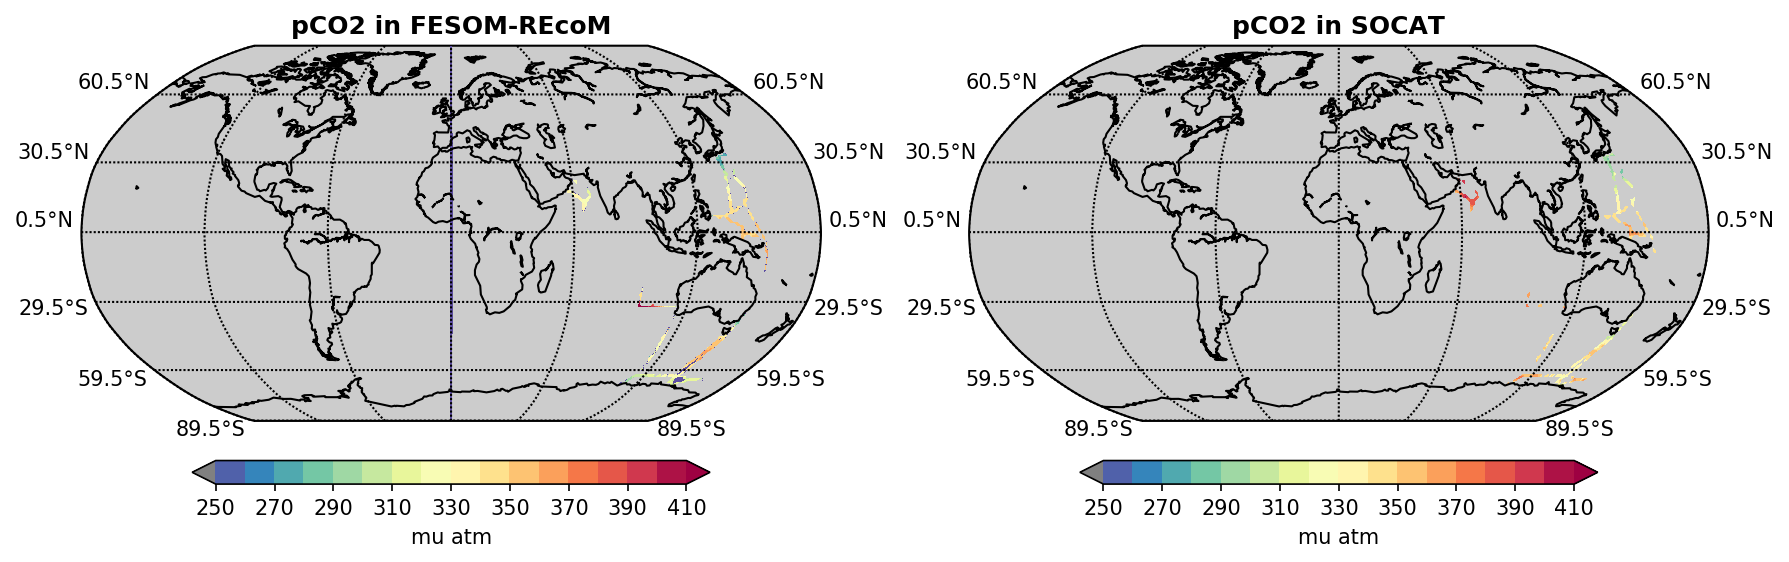

In [7]:
#------
# test plot
#------

dpicnt = 150
levels = np.arange(250.,420.,10.)


time_entry = 300
data_plot1 = pco2_model_at_socat[time_entry,:,:]
data_plot2 = spco2_socatB[time_entry,:,:]
print data_plot1
print data_plot2

plt.figure(figsize=(14,7), dpi = dpicnt,facecolor='w', edgecolor='k') 

plt.subplot(1,2,1)
map = Basemap(projection='robin',lon_0=0)
X2, Y2 = np.meshgrid(lon_model, lat_model) 
x, y = map(X2,Y2)
#x, y = map(lon,lat)
map.drawmapboundary(fill_color='0.8')
map.drawcoastlines()
map.drawparallels(np.arange(-89.5,89.5,30),labels=[True,True,True,True]) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[False,False,False,False]) #[0,0,0,1]
map.drawcoastlines(linewidth=0.25)
plt.title('pCO2 in FESOM-REcoM',fontsize=12,fontweight='bold')
#im=plt.pcolor(x, y, data_plot)#, levels=levels,cmap=cm.Spectral_r, extend='both')
im=plt.contourf(x, y, data_plot1, levels=levels,cmap=cm.Spectral_r, extend='both')
cbar=plt.colorbar(orientation='horizontal',shrink=0.7,pad=0.05)
cbar.ax.set_xlabel('mu atm') 
cbar.cmap.set_under('grey')

plt.subplot(1,2,2)
map = Basemap(projection='robin',lon_0=0)
X2, Y2 = np.meshgrid(lon_model, lat_model) 
x, y = map(X2,Y2)
#x, y = map(lon,lat)
map.drawmapboundary(fill_color='0.8')
map.drawcoastlines()
map.drawparallels(np.arange(-89.5,89.5,30),labels=[True,True,True,True]) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[False,False,False,False]) #[0,0,0,1]
map.drawcoastlines(linewidth=0.25)
plt.title('pCO2 in SOCAT',fontsize=12,fontweight='bold')
#im=plt.pcolor(x, y, data_plot)#, levels=levels,cmap=cm.Spectral_r, extend='both')
im=plt.contourf(x, y, data_plot2, levels=levels,cmap=cm.Spectral_r, extend='both')
cbar=plt.colorbar(orientation='horizontal',shrink=0.7,pad=0.05)
cbar.ax.set_xlabel('mu atm') 
cbar.cmap.set_under('grey')
plt.savefig(savepath+'pCO2_map_FESOMcoloc_vs_SOCAT_test.png',\
            dpi = dpicnt, bbox_inches='tight')
plt.show()
        

In [8]:
#-----
# convert SOCAT obs and coloated model output to one vector (for scatter plots below)
#-----

pco2_model_at_socat_list = pco2_model_at_socat.ravel()
sst_model_at_socat_list  = sst_model_at_socat.ravel()
sss_model_at_socat_list  = sss_model_at_socat.ravel()
chl_model_at_socat_list  = chl_model_at_socat.ravel()
mld_model_at_socat_list  = mld_model_at_socat.ravel()
ssh_model_at_socat_list  = ssh_model_at_socat.ravel()
socat_list          = spco2_socatB.ravel()
print socat_list.shape
print pco2_model_at_socat_list.shape
indnoNaN=np.where(socat_list>-9999.0)[0] 
socat_list = socat_list[indnoNaN]
pco2_model_at_socat_list = pco2_model_at_socat_list[indnoNaN]
sst_model_at_socat_list  = sst_model_at_socat_list[indnoNaN]
sss_model_at_socat_list  = sss_model_at_socat_list[indnoNaN]
chl_model_at_socat_list  = chl_model_at_socat_list[indnoNaN]
mld_model_at_socat_list  = mld_model_at_socat_list[indnoNaN]
ssh_model_at_socat_list  = ssh_model_at_socat_list[indnoNaN]
print socat_list.shape
print pco2_model_at_socat_list.shape

(38102400,)
(38102400,)
(298602,)
(298602,)


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [9]:
@njit
def get_closest_grid_point(lon_point, lat_point, lon2, lat2):  
    # in all nodes in mesh, return the index of the closest node to lon_point/lat_point
    # lon2 & lat2 are the locations in the new mesh (to be redistributed to)
    # lon2 & lat2 should be in radians
    # numpy needs to be imported outside the function
    
    #from math import sin, cos, sqrt, atan2, radians
    #import numpy as np
    # approximate radius of earth in km
    R = 6373.0
    
    #lat2 = radians(mesh.y2) # all positions in mesh
    #lon2 = radians(mesh.x2)
    #lat2 = [radians(x) for x in mesh.y2]
    #lon2 = [radians(x) for x in mesh.x2]
    lat1 = radians(lat_point)
    lon1 = radians(lon_point)
    bb1 = cos(lat1)
    
    all_distances = np.zeros(len(lon2))
    for i in range(0,len(lon2)):
        dlon = lon2[i] - lon1
        dlat = lat2[i] - lat1
        a = sin(dlat / 2)**2 + bb1 * cos(lat2[i]) * sin(dlon / 2)**2
        all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # to speed things up, omit constant factors here!
        #all_distances[i] = 2*R*atan2(sqrt(a), sqrt(1 - a)) # correct distance
        #del dlon, dlat, a
    index_closest_node = np.argmin(all_distances)
    distance_closest_node = np.min(all_distances)

    return index_closest_node, distance_closest_node

In [10]:
#-------
# go through SOCCOM locations and assign closest grid cell in 1°x1° grid and assign month
#-------

from datetime import datetime
from datetime import date, timedelta

num_soccom = len(np.squeeze(lon_soccom))
print 'Number of obs in SOCAT: ',num_soccom

# convert to radians, transform to one vector
lat_socat_rad  = [radians(x) for x in lat_socat]
lon_socatB_rad = [radians(x) for x in lon_socatB]
lon_socatB_rad2,lat_socat_rad2 = np.meshgrid(lon_socatB_rad,lat_socat_rad)
lon_socatB_rad2 = lon_socatB_rad2.ravel()
lat_socat_rad2  = lat_socat_rad2.ravel()

# loop over all SOCCOM points
start = date(1950,1,1) # SOCCOM time is in "days since 1950-01-01"
ind_location = np.zeros(num_soccom)
lon_colocated  = np.zeros(num_soccom)
lat_colocated  = np.zeros(num_soccom)
ind_time = np.zeros([num_soccom,3]) # day,month,year
for ii in range(0,num_soccom):
    if np.mod(ii,500)==0:
        print str(ii)+'/'+str(num_soccom)
    # get closest point
    index_closest_node, distance = get_closest_grid_point(lon_soccom[0,ii], lat_soccom[0,ii],\
                                                          lon_socatB_rad2, lat_socat_rad2)
    ind_location[ii]=index_closest_node
    lon_colocated[ii]=degrees(lon_socatB_rad2[index_closest_node])
    lat_colocated[ii]=degrees(lat_socat_rad2[index_closest_node])
    del distance,index_closest_node
    
    # deal with time: extract day/month/year from timestamp in file 
    #   (to later extract model data at right month/year)
    days = int(time_soccom[0,ii])
    delta = timedelta(days)
    offset = start + delta
    ind_time[ii,0] = offset.day
    ind_time[ii,1] = offset.month
    ind_time[ii,2] = offset.year
    del days,delta,offset

Number of obs in SOCAT:  6314
0/6314
500/6314
1000/6314
1500/6314
2000/6314
2500/6314
3000/6314
3500/6314
4000/6314
4500/6314
5000/6314
5500/6314
6000/6314


In [11]:
#------
# extract model data (SOCCOM)
#------

pco2_model_at_soccom = -9999*np.ones(num_soccom)
sst_model_at_soccom  = -9999*np.ones(num_soccom)
sss_model_at_soccom  = -9999*np.ones(num_soccom)
chl_model_at_soccom  = -9999*np.ones(num_soccom)
mld_model_at_soccom  = -9999*np.ones(num_soccom)
ssh_model_at_soccom  = -9999*np.ones(num_soccom)
mask_soccom_socat = np.zeros([588,180,360]) # is set to one where there is a SOCCOM obs
#print mask_soccom_socat
d3_list = np.zeros(num_soccom)
for ii in range(0,num_soccom):
    #if np.mod(ii,500)==0:
    #    print str(ii)+'/'+str(num_soccom)
    if ind_time[ii,2]<year2+1: # exclude 2020 data (not available in model)
        # lon
        d1 = np.argmin(np.abs(lon_colocated[ii]-lon_socatB)) 
        # lat
        d2 = np.argmin(np.abs(lat_colocated[ii]-lat_socat))
        # time
        d3_list[ii] = 12*(ind_time[ii,2]-year1-1)+ind_time[ii,1]
        d3 = 12*(ind_time[ii,2]-year1-1)+ind_time[ii,1]
        pco2_model_at_soccom[ii] = pco2_model[int(d3)-1,int(d2),int(d1)]
        sst_model_at_soccom[ii]  = sst_model[int(d3)-1,int(d2),int(d1)]
        sss_model_at_soccom[ii]  = sss_model[int(d3)-1,int(d2),int(d1)]
        chl_model_at_soccom[ii]  = chl_model[int(d3)-1,int(d2),int(d1)]
        mld_model_at_soccom[ii]  = mld_model[int(d3)-1,int(d2),int(d1)]
        ssh_model_at_soccom[ii]  = ssh_model[int(d3)-1,int(d2),int(d1)]  # TO ADD!
        mask_soccom_socat[int(d3)-1,int(d2),int(d1)] = 1.0 
        del d1,d2,d3

# extract data at SOCCOM locations on a 3D array
pco2_model_at_soccom_3D = -9999*np.ones_like(pco2_model_at_socat)
sst_model_at_soccom_3D  = -9999*np.ones_like(pco2_model_at_socat)
sss_model_at_soccom_3D  = -9999*np.ones_like(pco2_model_at_socat)
chl_model_at_soccom_3D  = -9999*np.ones_like(pco2_model_at_socat)
mld_model_at_soccom_3D  = -9999*np.ones_like(pco2_model_at_socat)
ssh_model_at_soccom_3D  = -9999*np.ones_like(pco2_model_at_socat)
pco2_model_at_soccom_3D = np.multiply(mask_soccom_socat,pco2_model)
sst_model_at_soccom_3D  = np.multiply(mask_soccom_socat,sst_model)
sss_model_at_soccom_3D  = np.multiply(mask_soccom_socat,sss_model)
chl_model_at_soccom_3D  = np.multiply(mask_soccom_socat,chl_model)
mld_model_at_soccom_3D  = np.multiply(mask_soccom_socat,mld_model)
ssh_model_at_soccom_3D  = np.multiply(mask_soccom_socat,ssh_model)

# set masked values to -9999
pco2_model_at_soccom_3D[pco2_model_at_soccom_3D.mask]=-9999
sst_model_at_soccom_3D[sst_model_at_soccom_3D.mask]=-9999
sss_model_at_soccom_3D[sss_model_at_soccom_3D.mask]=-9999
chl_model_at_soccom_3D[chl_model_at_soccom_3D.mask]=-9999
mld_model_at_soccom_3D[mld_model_at_soccom_3D.mask]=-9999
ssh_model_at_soccom_3D[ssh_model_at_soccom_3D.mask]=-9999
pco2_model_at_soccom_3D[pco2_model_at_soccom_3D==0]=-9999
sst_model_at_soccom_3D[sst_model_at_soccom_3D==0]=-9999
sss_model_at_soccom_3D[sss_model_at_soccom_3D==0]=-9999
chl_model_at_soccom_3D[chl_model_at_soccom_3D==0]=-9999
mld_model_at_soccom_3D[mld_model_at_soccom_3D==0]=-9999
ssh_model_at_soccom_3D[ssh_model_at_soccom_3D==0]=-9999

#------
# kick out data from 2020 from list
#------
print pco2_model_at_soccom.shape
ind0 = np.where(pco2_model_at_soccom>-999.)[0]
pco2_model_at_soccom = pco2_model_at_soccom[ind0]
sst_model_at_soccom = sst_model_at_soccom[ind0]
sss_model_at_soccom = sss_model_at_soccom[ind0]
chl_model_at_soccom = chl_model_at_soccom[ind0]
mld_model_at_soccom = mld_model_at_soccom[ind0]
ssh_model_at_soccom = ssh_model_at_soccom[ind0]   # TO ADD
spco2_soccom_before2020  = spco2_soccom[0,ind0]
lon_colocated_before2020 = lon_colocated[ind0]
lat_colocated_before2020 = lat_colocated[ind0]
info_time_before2020     = ind_time[ind0,:]
print pco2_model_at_soccom.shape

/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Warning: converting a masked element to nan.
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Warning: converting a masked element to nan.
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Warning: converting a masked element to nan.
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: Warning: converting a masked element to nan.
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:29: UserWarning: Warning: converting a masked element to nan.
/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Warning: converting a masked element to nan.


(6314,)
(4863,)


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in greater


(588, 180, 360)
(array([20, 20, 24, 25, 25, 26, 26, 27, 30, 30, 31, 31, 31, 31, 31, 32, 32,
       32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 36, 36, 36,
       36, 36, 36, 36, 36, 38, 38, 38, 38, 38, 38, 39, 39, 40, 40, 41, 42,
       42, 42, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 49, 50, 51, 51,
       55, 56]), array([338, 339,   4, 193, 194, 257, 258,  83, 213, 214, 167, 193, 194,
       310, 311,  88,  89, 165, 194, 195,  84, 169, 300,  98,  99, 100,
       196, 234, 293, 295, 195,  17,  20, 209, 302, 304, 305, 328, 329,
        97,  98, 208, 210, 317, 318,  98, 319, 278, 279, 249, 103, 107,
       202, 102, 106, 107, 103, 185, 186, 187, 188, 312, 187, 312, 206,
        94, 188, 194,  15,  16]))


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


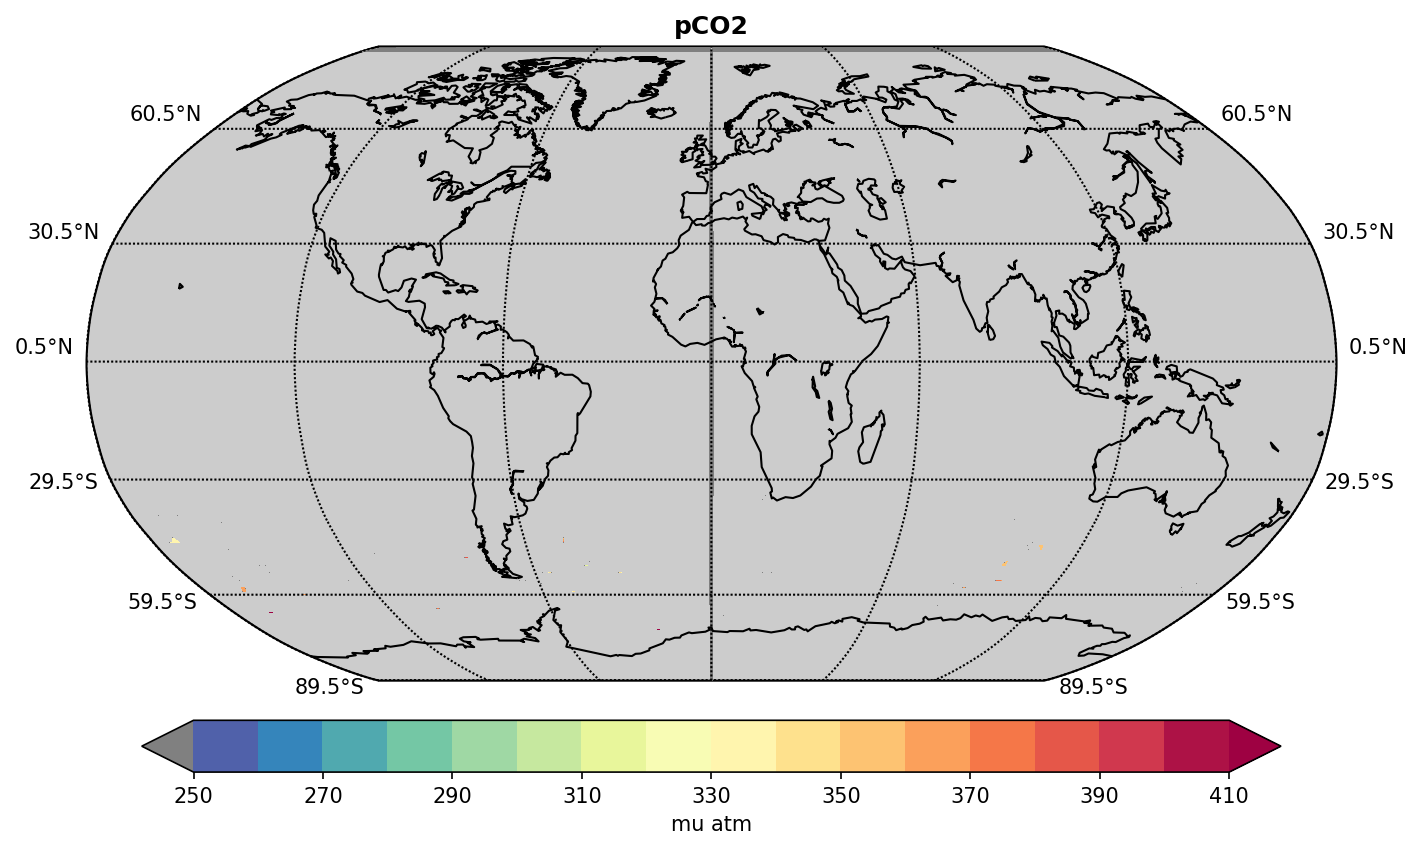

In [12]:
#------
# test plot for SOCCOM colocation
#------

time_entry = 550
print pco2_model_at_soccom_3D.shape
data_plot1 = pco2_model_at_soccom_3D[time_entry,:,:]
#data_plot1[data_plot1.mask]=-9999
#print data_plot1
print np.where(data_plot1>0)

plt.figure(figsize=(14,7), dpi = dpicnt,facecolor='w', edgecolor='k') 

map = Basemap(projection='robin',lon_0=0)
X2, Y2 = np.meshgrid(lon_model, lat_model) 
x, y = map(X2,Y2)
#x, y = map(lon,lat)
map.drawmapboundary(fill_color='0.8')
map.drawcoastlines()
map.drawparallels(np.arange(-89.5,89.5,30),labels=[True,True,True,True]) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[False,False,False,False]) #[0,0,0,1]
map.drawcoastlines(linewidth=0.25)
plt.title('pCO2',fontsize=12,fontweight='bold')
#im=plt.pcolor(x, y, data_plot)#, levels=levels,cmap=cm.Spectral_r, extend='both')
im=plt.contourf(x, y, data_plot1, levels=levels,cmap=cm.Spectral_r, extend='both')
cbar=plt.colorbar(orientation='horizontal',shrink=0.7,pad=0.05)
cbar.ax.set_xlabel('mu atm') 
cbar.cmap.set_under('grey')
plt.savefig(savepath+'pCO2_map_FESOMcoloc_at_SOCCOM_test.png',\
            dpi = dpicnt, bbox_inches='tight')
plt.show()

In [13]:
extract_from_native_mesh = True
if extract_from_native_mesh:
    #-------
    # do the same for original FESOM output: extract model output at SOCCOM locations, part I
    #-------

    # load mesh, get lat/lon
    meshpath   = '/work/ollie/jhauck/input/meshes/core_new_384/'
    mesh       = load_mesh(meshpath,abg=[0,0,0])

    mesh_lat = mesh.y2
    mesh_lon = mesh.x2
    # convert to radians, transform to one vector
    mesh_lat_rad2 = [radians(x) for x in mesh_lat]
    mesh_lon_rad2 = [radians(x) for x in mesh_lon]
    #mesh_lon_rad2,mesh_lat_rad2 = np.meshgrid(mesh_lon_rad,mesh_lat_rad)
    #mesh_lon_rad2 = mesh_lon_rad2.ravel()
    #mesh_lat_rad2 = mesh_lat_rad2.ravel()

usepickle =  False
abg =  [0, 0, 0]
no pickle
Load 2d part of the grid in 5 second(s)
Load 3d part of the grid in 13 seconds


In [14]:
if extract_from_native_mesh:

    #-------
    # do the same for original FESOM output: extract model output at SOCCOM locations, part II
    #-------

    num_soccom = len(np.squeeze(lon_soccom))

    # loop over all SOCCOM points
    start = date(1950,1,1) # SOCCOM time is in "days since 1950-01-01"
    ind_location_ORIGINAL   = np.zeros(num_soccom)
    lon_colocated_ORIGINAL  = np.zeros(num_soccom)
    lat_colocated_ORIGINAL  = np.zeros(num_soccom)
    ind_time_ORIGINAL = np.zeros([num_soccom,3]) # day,month,year
    for ii in range(0,num_soccom):
        if np.mod(ii,500)==0:
            print str(ii)+'/'+str(num_soccom)
        # get closest point
        index_closest_node, distance = get_closest_grid_point(lon_soccom[0,ii], lat_soccom[0,ii],\
                                                              mesh_lon_rad2, mesh_lat_rad2)
        ind_location_ORIGINAL[ii]=index_closest_node
        lon_colocated_ORIGINAL[ii]=degrees(mesh_lon_rad2[index_closest_node])
        lat_colocated_ORIGINAL[ii]=degrees(mesh_lat_rad2[index_closest_node])
        del distance,index_closest_node

        # deal with time: extract day/month/year from timestamp in file (to later extract model data at right time)
        days = int(time_soccom[0,ii])
        delta = timedelta(days)
        offset = start + delta
        ind_time_ORIGINAL[ii,0] = offset.day
        ind_time_ORIGINAL[ii,1] = offset.month
        ind_time_ORIGINAL[ii,2] = offset.year
        del days,delta,offset


0/6314
500/6314
1000/6314
1500/6314
2000/6314
2500/6314
3000/6314
3500/6314
4000/6314
4500/6314
5000/6314
5500/6314
6000/6314


In [15]:
if extract_from_native_mesh:
    #-------
    # do the same for original FESOM output: extract model output at SOCCOM locations, part III
    #-------
    #------
    # extract model data
    #------

    pco2_model_at_soccom_ORGINAL = -9999*np.ones(num_soccom)
    sst_model_at_soccom_ORGINAL  = -9999*np.ones(num_soccom)
    sss_model_at_soccom_ORGINAL  = -9999*np.ones(num_soccom)
    chl_model_at_soccom_ORGINAL  = -9999*np.ones(num_soccom)
    mld_model_at_soccom_ORGINAL  = -9999*np.ones(num_soccom)
    ssh_model_at_soccom_ORGINAL  = -9999*np.ones(num_soccom) 
    for ii in range(0,num_soccom):
        if np.mod(ii,500)==0:
            print str(ii)+'/'+str(num_soccom)
        if ind_time[ii,2]<year2+1: # exclude 2020 data (not available in model)
            # load data for present year
            file_pco2_recom = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/pCO2s_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_sst_recom = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/tos_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_sss_recom = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/sos_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_mld_recom = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/mlotst_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_chl_recom1 = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/bgc06_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_chl_recom2 = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/bgc15_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            file_ssh_recom  = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019/zos_fesom_'+\
                str(int(ind_time[ii,2]))+'0101.nc'
            #print 'load '+file_recom
            f1 = Dataset(file_pco2_recom)
            data_pco2_recom = f1.variables['pCO2s'][:]
            f2 = Dataset(file_sst_recom)
            data_sst_recom = f2.variables['tos'][:]
            f3 = Dataset(file_sss_recom)
            data_sss_recom = f3.variables['sos'][:]
            f4 = Dataset(file_mld_recom)
            data_mld_recom = f4.variables['mlotst'][:]
            f5 = Dataset(file_chl_recom1)
            f6 = Dataset(file_chl_recom2)
            data_chl_recom1 = f5.variables['bgc06'][:,0,:] # load surface only
            data_chl_recom2 = f6.variables['bgc15'][:,0,:] # load surface only
            data_chl_recom = data_chl_recom1 + data_chl_recom2
            f7 = Dataset(file_ssh_recom)
            data_ssh_recom = f7.variables['zos'][:]
            f1.close()
            f2.close()
            f3.close()
            f4.close()
            f5.close()
            f6.close()
            f7.close()
            del data_chl_recom1,data_chl_recom2
            #del f1,f2,f3,f4,f5,f6,f7

            # location (lon & lat)
            d1 = ind_location_ORIGINAL[ii]
            # time
            d3 = ind_time[ii,1] #12*(ind_time[ii,2]-year1-1)+ind_time[ii,1]
            pco2_model_at_soccom_ORGINAL[ii] = data_pco2_recom[int(d3)-1,int(d1)]
            sst_model_at_soccom_ORGINAL[ii] = data_sst_recom[int(d3)-1,int(d1)]
            sss_model_at_soccom_ORGINAL[ii] = data_sss_recom[int(d3)-1,int(d1)]
            chl_model_at_soccom_ORGINAL[ii] = data_chl_recom[int(d3)-1,int(d1)]
            mld_model_at_soccom_ORGINAL[ii] = data_mld_recom[int(d3)-1,int(d1)]
            ssh_model_at_soccom_ORGINAL[ii] = data_ssh_recom[int(d3)-1,int(d1)]  
            del d1,d3,data_pco2_recom,data_mld_recom,data_sss_recom,data_sst_recom,data_chl_recom,data_ssh_recom
            del file_chl_recom1,file_chl_recom2,file_mld_recom,file_sss_recom,file_sst_recom,file_pco2_recom

    #------
    # kick out data from 2020 from list
    #------
    print pco2_model_at_soccom_ORGINAL.shape
    ind0_original = np.where(pco2_model_at_soccom_ORGINAL>-999.)[0]
    print np.setdiff1d(ind0_original,ind0) # these are the indices that are kicked out above due to landsea mask
    # use ind0 here, so that both vectors have the same length
    pco2_model_at_soccom_ORGINAL = pco2_model_at_soccom_ORGINAL[ind0]
    sst_model_at_soccom_ORGINAL = sst_model_at_soccom_ORGINAL[ind0]
    sss_model_at_soccom_ORGINAL = sss_model_at_soccom_ORGINAL[ind0]
    chl_model_at_soccom_ORGINAL = chl_model_at_soccom_ORGINAL[ind0]
    mld_model_at_soccom_ORGINAL = mld_model_at_soccom_ORGINAL[ind0]
    ssh_model_at_soccom_ORGINAL = ssh_model_at_soccom_ORGINAL[ind0]   
    #spco2_soccom_before2020  = spco2_soccom[0,ind0] # already reduced above 

    lon_colocated_ORIGINAL_before2020 = lon_colocated_ORIGINAL[ind0]
    lat_colocated_ORIGINAL_before2020 = lat_colocated_ORIGINAL[ind0]
    info_time_ORIGINAL_before2020     = ind_time_ORIGINAL[ind0,:]
    print pco2_model_at_soccom_ORGINAL.shape
    
    print len(ind0_original)
    print len(ind0) # because of landsea mask, this excludes 3 data points more than when using original model output

0/6314
500/6314
1000/6314
1500/6314
2000/6314
2500/6314
3000/6314
3500/6314
4000/6314
4500/6314
5000/6314
5500/6314
6000/6314
(6314,)
[5779 5781 5782]
(4863,)
4866
4863


In [ ]:
print len(ind0_original)
print len(ind0) 
print ind0_original
print ind0

print np.setdiff1d(ind0_original,ind0)

print pco2_model_at_soccom_ORGINAL.shape
print pco2_model_at_soccom.shape
print np.min(pco2_model_at_soccom_ORGINAL)

In [ ]:
#
# PLOTS (scatter)
#

In [ ]:
#------
# plot: original SOCAT/SOCCOM pCO2 data vs extracted model data
#------
xlim1,xlim2 = 20,950
ylim1,ylim2 = 20,950
lw = 2
fs = 15

f=plt.figure(figsize=(12,5), facecolor='w', edgecolor='k') 
plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)

plt.subplot(1,2,1)
plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
plt.plot(spco2_soccom_before2020,pco2_model_at_soccom,'bo')
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
plt.xlabel('pCO$_{2}$ in SOCCOM',fontsize=fs)
plt.ylabel('pCO$_{2}$ in FESOM-REcoM',fontsize=fs)

plt.subplot(1,2,2)
plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
plt.plot(socat_list,pco2_model_at_socat_list,'bo')
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
plt.xlabel('pCO$_{2}$ in SOCAT',fontsize=fs)
plt.ylabel('pCO$_{2}$ in FESOM-REcoM',fontsize=fs)
plt.savefig(savepath+'pCO2_scatter_FESOMcoloc_vs_SOCAT_and_SOCCOM.png',\
            dpi = dpicnt, bbox_inches='tight')

plt.show()



In [ ]:
#------
# plot: original SOCCOM pCO2 data vs extracted model data vs month/year
#------

xlim1,xlim2 = 200,910
ylim1,ylim2 = 200,910
lw = 2
fs = 15
circle_size = 8

f=plt.figure(figsize=(12,5), facecolor='w', edgecolor='k') 
plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)

plt.subplot(1,2,1)
plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
plt.scatter(spco2_soccom_before2020,pco2_model_at_soccom,\
            s=circle_size,c=info_time_before2020[:,1],cmap=cm.Spectral_r)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
plt.xlabel('pCO$_{2}$ in SOCCOM',fontsize=fs)
plt.ylabel('pCO$_{2}$ in FESOM-REcoM',fontsize=fs)
cbar=plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.85) #im,"bottom",
cbar.set_label('Month',fontsize=fs-1)
cbar.ax.tick_params(labelsize=fs-2)

plt.subplot(1,2,2)
plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
plt.scatter(spco2_soccom_before2020,pco2_model_at_soccom,\
            s=circle_size,c=info_time_before2020[:,2],cmap=cm.Spectral_r)
plt.xlim((xlim1,xlim2))
plt.ylim((ylim1,ylim2))
plt.xlabel('pCO$_{2}$ in SOCCOM',fontsize=fs)
plt.ylabel('pCO$_{2}$ in FESOM-REcoM',fontsize=fs)
cbar=plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.85) #im,"bottom",
cbar.set_label('Year',fontsize=fs-1)
cbar.ax.tick_params(labelsize=fs-2)
plt.savefig(savepath+'pCO2_scatter_FESOMcoloc_vs_SOCCOM_vs_time.png',\
            dpi = dpicnt, bbox_inches='tight')

plt.show()

In [ ]:
#------
# plot: original SOCCOM pCO2 data vs extracted model data vs year (one figure per year)
#------

xlim1,xlim2 = 200,910
ylim1,ylim2 = 200,910
lw = 2
fs = 13
circle_size = 16

f=plt.figure(figsize=(15,8), facecolor='w', edgecolor='k') 
plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.4)
counter = 1
for yy in range(2014,2020):
    
    plt.subplot(2,3,counter)
    ind_year = np.where(info_time_before2020[:,2]==yy)[0]
    plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
    plt.scatter(spco2_soccom_before2020[ind_year],pco2_model_at_soccom[ind_year],\
                s=circle_size,c=info_time_before2020[ind_year,1],cmap=cm.Spectral_r)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    plt.title(yy,fontsize=fs,fontweight='bold')
    plt.xlabel('pCO$_{2}$ in SOCCOM',fontsize=fs)
    plt.ylabel('pCO$_{2}$ in FESOM-REcoM',fontsize=fs)
    cbar=plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.85) #im,"bottom",
    cbar.set_label('Month',fontsize=fs-1)
    #cbar.cmap.set_under('w')
    cbar.ax.tick_params(labelsize=fs-2)
    plt.annotate(str(len(ind_year))+' obs ('+str(100*len(ind_year)/len(info_time_before2020[:,2]))+'%)',\
                 xy=(0.6,0.05), xycoords='axes fraction',fontsize=8,color='black')
    counter = counter+1
plt.savefig(savepath+'pCO2_scatter_FESOMcoloc_vs_SOCCOM_vs_years.png',\
            dpi = dpicnt, bbox_inches='tight')
plt.show()

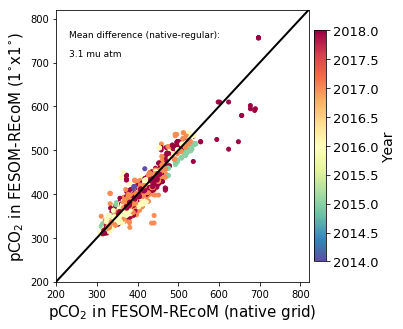

Mean difference (native-regular):  3.10694255433


In [27]:
if extract_from_native_mesh:
    #------
    # plot: SOCCOM extracted model data:  1x1 grid vs native model grid
    #------
    xlim1,xlim2 = 200,820
    ylim1,ylim2 = 200,820
    lw = 2
    fs = 15
    circle_size = 16

    f=plt.figure(figsize=(5,5), facecolor='w', edgecolor='k') 
    plt.subplots_adjust(wspace=0.4)
    plt.subplots_adjust(hspace=0.4)

    plt.plot(range(xlim1,xlim2),range(ylim1,ylim2),'k',linestyle='-',linewidth=lw)
    #plt.plot(pco2_model_at_soccom_ORGINAL,pco2_model_at_soccom,'bo')
    plt.scatter(pco2_model_at_soccom_ORGINAL,pco2_model_at_soccom,\
                s=circle_size,c=info_time_before2020[:,2],cmap=cm.Spectral_r)
    plt.xlim((xlim1,xlim2))
    plt.ylim((ylim1,ylim2))
    plt.xlabel('pCO$_{2}$ in FESOM-REcoM (native grid)',fontsize=fs)
    plt.ylabel('pCO$_{2}$ in FESOM-REcoM (1$^{\circ}$x1$^{\circ}$)',fontsize=fs)
    cbar=plt.colorbar(orientation='vertical',fraction=0.075, pad=0.02,shrink=0.85) #im,"bottom",
    cbar.set_label('Year',fontsize=fs-1)
    #cbar.cmap.set_under('w')
    cbar.ax.tick_params(labelsize=fs-2)
    plt.annotate('Mean difference (native-regular): ',xy=(0.05,0.9),\
                 xycoords='axes fraction',fontsize=9,color='black')
    plt.annotate(str(np.round(10*np.mean(pco2_model_at_soccom_ORGINAL-pco2_model_at_soccom))/10)+' mu atm',\
                 xy=(0.05,0.83),\
                 xycoords='axes fraction',fontsize=9,color='black')
    plt.savefig(savepath+'pCO2_scatter_FESOMcoloc_wSOCCOM_native_vs_regGrid_vs_years.png',\
            dpi = dpicnt, bbox_inches='tight')
    plt.show()
    
    print 'Mean difference (native-regular): ',np.mean(pco2_model_at_soccom_ORGINAL-pco2_model_at_soccom)
    

In [23]:
print info_time_before2020.shape

(4863, 3)


In [ ]:
#------
# save netcdf file of extracted model output (SOCAT)
#------

savepath = '/work/ollie/ncara/RECCAPv2/subsampling/'
fill_value = -9999

save_file = True
if save_file:
    # save as netcdf
    save_name     = savepath+'FESOM_REcoM_output_at_SOCAT_locations.nc'
    print 'create '+save_name
    
    w_nc_fid = Dataset(save_name, 'w', format='NETCDF4_CLASSIC')
    w_nc_fid.history='see MASTER_FESOM_output_at_SOCAT_points.ipynb'
    w_nc_fid.socat_source= socatfile

    # create dimension & variable
    w_nc_fid.createDimension('time', tsteps) 
    w_nc_fid.createDimension('lon', len(lon_socatB)) 
    w_nc_fid.createDimension('lat', len(lat_socat)) 
    
    w_nc_var1 = w_nc_fid.createVariable('lat', 'f8',('lat'))
    w_nc_var2 = w_nc_fid.createVariable('lon', 'f8',('lon'))
    w_nc_var3 = w_nc_fid.createVariable('time', 'f8',('time'))
    w_nc_var3.description = 'time'
    w_nc_var3.unit = 'months since '+str(year1)+'-01-01 0:0:0'
    
    w_nc_var10 = w_nc_fid.createVariable('landsea_mask', 'f8',('lat','lon'))
    w_nc_var10.description = 'Land sea mask applied to model output before subsampling; 0=land, 1=ocean' 
    w_nc_var10.source = path_lsmask
    
    w_nc_var4 = w_nc_fid.createVariable('pCO2_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var4.description = 'pCO2 from FESOM-REcoM at SOCAT locations' 
    w_nc_var4.source = pco2file
    w_nc_var4.unit = 'mu atm'
    
    w_nc_var5 = w_nc_fid.createVariable('SST_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var5.description = 'SST from FESOM-REcoM at SOCAT locations' 
    w_nc_var5.source = SSTfile
    w_nc_var5.unit = 'deg C'
    
    w_nc_var6 = w_nc_fid.createVariable('SSS_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var6.description = 'SSS (practical salinity) from FESOM-REcoM at SOCAT locations' 
    w_nc_var6.source = SSSfile
    w_nc_var6.unit = 'g/kg'
    
    w_nc_var7 = w_nc_fid.createVariable('chl_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var7.description = 'total chl from FESOM-REcoM at SOCAT locations' 
    w_nc_var7.source = Chlfile
    w_nc_var7.unit = 'mg chl m-3'
    
    w_nc_var8 = w_nc_fid.createVariable('MLD_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var8.description = 'MLD from FESOM-REcoM (0.03 kg m-3 criterion) at SOCAT locations' 
    w_nc_var8.source = MLDfile
    w_nc_var8.unit = 'm'
    
    w_nc_var9 = w_nc_fid.createVariable('ZOS_at_SOCAT', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var9.description = 'Dynamic sea level from FESOM-REcoM at SOCAT locations' 
    w_nc_var9.source = SSHfile
    w_nc_var9.unit = 'm'
    
    w_nc_fid.variables['pCO2_at_SOCAT'][:,:,:] = pco2_model_at_socat
    w_nc_fid.variables['SST_at_SOCAT'][:,:,:] = sst_model_at_socat
    w_nc_fid.variables['SSS_at_SOCAT'][:,:,:] = sss_model_at_socat
    w_nc_fid.variables['chl_at_SOCAT'][:,:,:] = chl_model_at_socat
    w_nc_fid.variables['MLD_at_SOCAT'][:,:,:] = mld_model_at_socat
    w_nc_fid.variables['ZOS_at_SOCAT'][:,:,:] = ssh_model_at_socat
    w_nc_fid.variables['landsea_mask'][:,:] = ls_mask_reccap
    
    w_nc_fid.variables['lat'][:] = lat_socat
    w_nc_fid.variables['lon'][:] = lon_socatB
    w_nc_fid.variables['time'][:] = range(1,tsteps+1)
    w_nc_fid.close()

In [ ]:
#------
# save netcdf file of extracted model output (SOCCOM)
#------

savepath = '/work/ollie/ncara/RECCAPv2/subsampling/'
fill_value = -9999

save_file = True
if save_file:
    # save as netcdf
    save_name     = savepath+'FESOM_REcoM_output_at_SOCCOM_locations.nc'
    print 'create '+save_name
    
    w_nc_fid = Dataset(save_name, 'w', format='NETCDF4_CLASSIC')
    w_nc_fid.history='see MASTER_FESOM_output_at_SOCAT_points.ipynb'
    w_nc_fid.soccom_source= soccomfile

    # create dimension & variable
    w_nc_fid.createDimension('time', tsteps) 
    w_nc_fid.createDimension('lon', len(lon_socatB)) 
    w_nc_fid.createDimension('lat', len(lat_socat)) 
    
    w_nc_var1 = w_nc_fid.createVariable('lat', 'f8',('lat'))
    w_nc_var2 = w_nc_fid.createVariable('lon', 'f8',('lon'))
    w_nc_var3 = w_nc_fid.createVariable('time', 'f8',('time'))
    w_nc_var3.description = 'time'
    w_nc_var3.unit = 'months since '+str(year1)+'-01-01 0:0:0'
    
    w_nc_var10 = w_nc_fid.createVariable('landsea_mask', 'f8',('lat','lon'))
    w_nc_var10.description = 'Land sea mask applied to model output before subsampling; 0=land, 1=ocean' 
    w_nc_var10.source = path_lsmask
    
    w_nc_var4 = w_nc_fid.createVariable('pCO2_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var4.description = 'pCO2 from FESOM-REcoM at SOCCOM locations' 
    w_nc_var4.source = pco2file
    w_nc_var4.unit = 'mu atm'
    
    w_nc_var5 = w_nc_fid.createVariable('SST_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var5.description = 'SST from FESOM-REcoM at SOCCOM locations' 
    w_nc_var5.source = SSTfile
    w_nc_var5.unit = 'deg C'
    
    w_nc_var6 = w_nc_fid.createVariable('SSS_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var6.description = 'SSS (practical salinity) from FESOM-REcoM at SOCAT locations' 
    w_nc_var6.source = SSSfile
    w_nc_var6.unit = 'g/kg'
    
    w_nc_var7 = w_nc_fid.createVariable('chl_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var7.description = 'total chl from FESOM-REcoM at SOCCOM locations' 
    w_nc_var7.source = Chlfile
    w_nc_var7.unit = 'mg chl m-3'
    
    w_nc_var8 = w_nc_fid.createVariable('MLD_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var8.description = 'MLD from FESOM-REcoM (0.03 kg m-3 criterion) at SOCCOM locations' 
    w_nc_var8.source = MLDfile
    w_nc_var8.unit = 'm'
    
    w_nc_var9 = w_nc_fid.createVariable('ZOS_at_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var9.description = 'Dynamic sea level from FESOM-REcoM at SOCCOM locations' 
    w_nc_var9.source = SSHfile
    w_nc_var9.unit = 'm'
    
    w_nc_fid.variables['pCO2_at_SOCCOM'][:,:,:] = pco2_model_at_soccom_3D
    w_nc_fid.variables['SST_at_SOCCOM'][:,:,:] = sst_model_at_soccom_3D
    w_nc_fid.variables['SSS_at_SOCCOM'][:,:,:] = sss_model_at_soccom_3D
    w_nc_fid.variables['chl_at_SOCCOM'][:,:,:] = chl_model_at_soccom_3D
    w_nc_fid.variables['MLD_at_SOCCOM'][:,:,:] = mld_model_at_soccom_3D
    w_nc_fid.variables['ZOS_at_SOCCOM'][:,:,:] = ssh_model_at_soccom_3D
    w_nc_fid.variables['landsea_mask'][:,:] = ls_mask_reccap
    w_nc_fid.variables['lat'][:] = lat_socat
    w_nc_fid.variables['lon'][:] = lon_socatB
    w_nc_fid.variables['time'][:] = range(1,tsteps+1)
    w_nc_fid.close()

In [ ]:
#-------
# combine SOCAT & SOCCOM
#-------

pco2_model_at_socat_and_soccom = -9999*np.ones_like(pco2_model_at_socat)
sst_model_at_socat_and_soccom  = -9999*np.ones_like(pco2_model_at_socat)
sss_model_at_socat_and_soccom  = -9999*np.ones_like(pco2_model_at_socat)
chl_model_at_socat_and_soccom  = -9999*np.ones_like(pco2_model_at_socat)
mld_model_at_socat_and_soccom  = -9999*np.ones_like(pco2_model_at_socat)
ssh_model_at_socat_and_soccom  = -9999*np.ones_like(pco2_model_at_socat)
for yy in range(0,tsteps):
    if np.mod(yy,50)==0:
        print 'Process month '+str(yy)+'/'+str(tsteps)
    for mm in range(0,180): # lat
        for nn in range(0,360): # lon
            if pco2_model_at_socat[yy,mm,nn]>-9999: 
                pco2_model_at_socat_and_soccom[yy,mm,nn] = pco2_model_at_socat[yy,mm,nn]
                sst_model_at_socat_and_soccom[yy,mm,nn]  = sst_model_at_socat[yy,mm,nn]
                sss_model_at_socat_and_soccom[yy,mm,nn]  = sss_model_at_socat[yy,mm,nn]
                chl_model_at_socat_and_soccom[yy,mm,nn]  = chl_model_at_socat[yy,mm,nn]
                mld_model_at_socat_and_soccom[yy,mm,nn]  = mld_model_at_socat[yy,mm,nn]
                ssh_model_at_socat_and_soccom[yy,mm,nn]  = ssh_model_at_socat[yy,mm,nn]
            if pco2_model_at_soccom_3D[yy,mm,nn]>-9999: 
                pco2_model_at_socat_and_soccom[yy,mm,nn] = pco2_model_at_soccom_3D[yy,mm,nn]
                sst_model_at_socat_and_soccom[yy,mm,nn]  = sst_model_at_soccom_3D[yy,mm,nn]
                sss_model_at_socat_and_soccom[yy,mm,nn]  = sss_model_at_soccom_3D[yy,mm,nn]
                chl_model_at_socat_and_soccom[yy,mm,nn]  = chl_model_at_soccom_3D[yy,mm,nn]
                mld_model_at_socat_and_soccom[yy,mm,nn]  = mld_model_at_soccom_3D[yy,mm,nn]
                ssh_model_at_socat_and_soccom[yy,mm,nn]  = ssh_model_at_soccom_3D[yy,mm,nn]
            if pco2_model_at_socat[yy,mm,nn]>-9999 and pco2_model_at_soccom_3D[yy,mm,nn]>-9999: 
                print 'both SOCAT & SOCCOM have data'           

print pco2_model_at_socat.shape
print pco2_model_at_soccom_3D.shape


In [ ]:
#------
# test plot
#------

dpicnt = 150
levels = np.arange(250.,420.,10.)


time_entry = 562
data_plot1 = pco2_model_at_socat[time_entry,:,:]
data_plot2 = pco2_model_at_socat_and_soccom[time_entry,:,:]
print 'non-zero obs in SOCAT: '+str(len(np.where(data_plot1>0)[0]))
print 'non-zero obs in SOCAT+SOCCOM: '+str(len(np.where(data_plot2>0)[0]))

plt.figure(figsize=(14,7), dpi = dpicnt,facecolor='w', edgecolor='k') 

plt.subplot(1,2,1)
map = Basemap(projection='robin',lon_0=0)
X2, Y2 = np.meshgrid(lon_model, lat_model) 
x, y = map(X2,Y2)
#x, y = map(lon,lat)
map.drawmapboundary(fill_color='0.8')
map.drawcoastlines()
map.drawparallels(np.arange(-89.5,89.5,30),labels=[True,True,True,True]) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[False,False,False,False]) #[0,0,0,1]
map.drawcoastlines(linewidth=0.25)
plt.title('pCO2 in FESOM-REcoM (SOCAT only)',fontsize=12,fontweight='bold')
#im=plt.pcolor(x, y, data_plot)#, levels=levels,cmap=cm.Spectral_r, extend='both')
im=plt.contourf(x, y, data_plot1, levels=levels,cmap=cm.Spectral_r, extend='both')
cbar=plt.colorbar(orientation='horizontal',shrink=0.7,pad=0.05)
cbar.ax.set_xlabel('mu atm') 
cbar.cmap.set_under('grey')

plt.subplot(1,2,2)
map = Basemap(projection='robin',lon_0=0)
X2, Y2 = np.meshgrid(lon_model, lat_model) 
x, y = map(X2,Y2)
#x, y = map(lon,lat)
map.drawmapboundary(fill_color='0.8')
map.drawcoastlines()
map.drawparallels(np.arange(-89.5,89.5,30),labels=[True,True,True,True]) #[1,0,0,0]
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[False,False,False,False]) #[0,0,0,1]
map.drawcoastlines(linewidth=0.25)
plt.title('pCO2 in FESOM-REcoM (SOCAT+SOCCOM)',fontsize=12,fontweight='bold')
#im=plt.pcolor(x, y, data_plot)#, levels=levels,cmap=cm.Spectral_r, extend='both')
im=plt.contourf(x, y, data_plot2, levels=levels,cmap=cm.Spectral_r, extend='both')
cbar=plt.colorbar(orientation='horizontal',shrink=0.7,pad=0.05)
cbar.ax.set_xlabel('mu atm') 
cbar.cmap.set_under('grey')
plt.savefig(savepath+'pCO2_map_FESOMcoloc_at_SOCAT_and_SOCCOM_test.png',\
            dpi = dpicnt, bbox_inches='tight')
plt.show()
        
# I think the horizontal lines are plotting artefacts...

In [ ]:
print data_plot1.shape

print np.where(lat_socat==-31.5)[0]
ind = np.where(lat_socat==-31.5)[0]

print lat_socat[52:64]
print np.max(data_plot1[58,:])
print data_plot1[58:60,:]

In [ ]:
#------
# save netcdf file of extracted model output (SOCCOM)
#------

savepath = '/work/ollie/ncara/RECCAPv2/subsampling/'
fill_value = -9999

save_file = True
if save_file:
    # save as netcdf
    save_name     = savepath+'FESOM_REcoM_output_at_SOCAT_and_SOCCOM_locations.nc'
    print 'create '+save_name
    
    w_nc_fid = Dataset(save_name, 'w', format='NETCDF4_CLASSIC')
    w_nc_fid.history='see MASTER_FESOM_output_at_SOCAT_points.ipynb'
    w_nc_fid.socat_source= socatfile
    w_nc_fid.soccom_source= soccomfile

    # create dimension & variable
    w_nc_fid.createDimension('time', tsteps) 
    w_nc_fid.createDimension('lon', len(lon_socatB)) 
    w_nc_fid.createDimension('lat', len(lat_socat)) 
    
    w_nc_var1 = w_nc_fid.createVariable('lat', 'f8',('lat'))
    w_nc_var2 = w_nc_fid.createVariable('lon', 'f8',('lon'))
    w_nc_var3 = w_nc_fid.createVariable('time', 'f8',('time'))
    w_nc_var3.description = 'time'
    w_nc_var3.unit = 'months since '+str(year1)+'-01-01 0:0:0'
    
    w_nc_var10 = w_nc_fid.createVariable('landsea_mask', 'f8',('lat','lon'))
    w_nc_var10.description = 'Land sea mask applied to model output before subsampling; 0=land, 1=ocean' 
    w_nc_var10.source = path_lsmask
    
    w_nc_var4 = w_nc_fid.createVariable('pCO2_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var4.description = 'pCO2 from FESOM-REcoM at SOCAT & SOCCOM locations' 
    w_nc_var4.source = pco2file
    w_nc_var4.unit = 'mu atm'
    
    w_nc_var5 = w_nc_fid.createVariable('SST_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var5.description = 'SST from FESOM-REcoM at SOCAT & SOCCOM locations' 
    w_nc_var5.source = SSTfile
    w_nc_var5.unit = 'deg C'
    
    w_nc_var6 = w_nc_fid.createVariable('SSS_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var6.description = 'SSS (practical salinity) from FESOM-REcoM at SOCAT & SOCAT locations' 
    w_nc_var6.source = SSSfile
    w_nc_var6.unit = 'g/kg'
    
    w_nc_var7 = w_nc_fid.createVariable('chl_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var7.description = 'total chl from FESOM-REcoM at SOCAT & SOCCOM locations' 
    w_nc_var7.source = Chlfile
    w_nc_var7.unit = 'mg chl m-3'
    
    w_nc_var8 = w_nc_fid.createVariable('MLD_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var8.description = 'MLD from FESOM-REcoM (0.03 kg m-3 criterion) at SOCAT & SOCCOM locations' 
    w_nc_var8.source = MLDfile
    w_nc_var8.unit = 'm'
    
    w_nc_var9 = w_nc_fid.createVariable('ZOS_at_SOCAT_SOCCOM', 'f8',('time','lat','lon'),fill_value=fill_value)
    w_nc_var9.description = 'Dynamic sea level from FESOM-REcoM at SOCAT & SOCCOM locations' 
    w_nc_var9.source = SSHfile
    w_nc_var9.unit = 'm'
    
    w_nc_fid.variables['pCO2_at_SOCAT_SOCCOM'][:,:,:] = pco2_model_at_socat_and_soccom
    w_nc_fid.variables['SST_at_SOCAT_SOCCOM'][:,:,:] = sst_model_at_socat_and_soccom
    w_nc_fid.variables['SSS_at_SOCAT_SOCCOM'][:,:,:] = sss_model_at_socat_and_soccom
    w_nc_fid.variables['chl_at_SOCAT_SOCCOM'][:,:,:] = chl_model_at_socat_and_soccom
    w_nc_fid.variables['MLD_at_SOCAT_SOCCOM'][:,:,:] = mld_model_at_socat_and_soccom
    w_nc_fid.variables['ZOS_at_SOCAT_SOCCOM'][:,:,:] = ssh_model_at_socat_and_soccom
    w_nc_fid.variables['landsea_mask'][:,:] = ls_mask_reccap
    w_nc_fid.variables['lat'][:] = lat_socat
    w_nc_fid.variables['lon'][:] = lon_socatB
    w_nc_fid.variables['time'][:] = range(1,tsteps+1)
    w_nc_fid.close()

In [ ]:
print np.max(chl_model_at_socat_and_soccom)